# Imports

In [2]:
# Array manipulation
import numpy as np

# Plotting the data
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError: 
    !pip install matplotlib==3.4.2
    import matplotlib.pyplot as plt
%matplotlib inline

# Tensor Operations
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset creation and handling
import os
import glob
from torch.utils.data import Dataset
try:
    from skimage import io
except ModuleNotFoundError:
    !pip install scikit-image
    from skimage import io

# Custom Dataset

An implementation of the PyTorch Dataset class. The class implementation loads the image data from .pi files. Each file is masked and thresholded. The remaining blob representing the cylinder is then dilated. The class returns a binary matrix, with all nonzero values representing the cylinder, as x value and the ground truth location of the cylinder as the y value.

In [3]:
os.chdir('./src/')
from custom_dataset import CMLRPiDataset

### Setup and Configurations

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"

# number of workers for the dataloader
num_workers = 0
batch_size = 32

# width and height of the table in the images captured by the top mounted camera
width = 120
height = 116

# add the transform
transform=transforms.Compose([non_zeros(width, height)])

# create the dataset
dataset = CMLRPiDataset(
    root_dir=DATASET_PATH,
    data_pi_name ='training_data.pt',
    mask_pi_name = 'no_cylinder.pt',
    threshold=200,
    add_img=True
)

# retrive the number of samples in the dataset 
dataset_len = dataset.__len__()


# split the dataset in test train and valdatuion
train_set, test_set, val_set = torch.utils.data.random_split(dataset, [int(dataset.__len__()*0.7), 
                                                                       int(dataset.__len__()*0.2), 
                                                                       (dataset.__len__()-int(dataset.__len__()*0.9))])

# definition of the corresponding data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)


## Visualize the data

In [4]:
# helper function to display images and mark to location of the detected cylinder
def imshow(img, non_zeros):
    """ Denormalize and plot image 
    
        Args:
            img: the image to be denormalized
            mean: The mean value
            std: 1/sdt value
    
    """
    plt.title("W: %i, H: %i " % (non_zeros[2], non_zeros[1]))
    plt.imshow(img)#.permute(1, 2, 0) )  # convert from Tensor image
    plt.scatter(non_zeros[2],non_zeros[1],marker="o", facecolors='none', edgecolors='r')

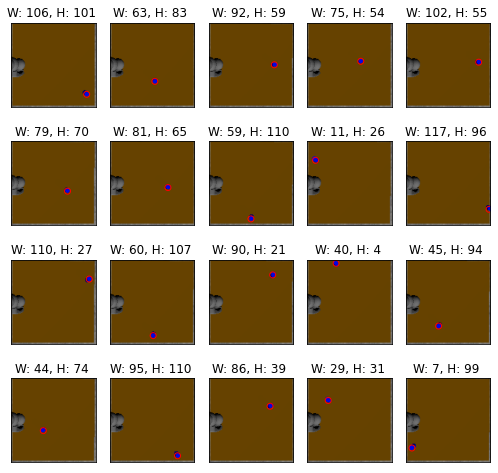

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels, original = dataiter.next()
fig = plt.figure(figsize=(7, 7))
fig.tight_layout()

"""
Display 20 images of the first batch. 
From the x values of the data loader detect the location of the nonzero values.
Take the mean of those loaction and mark them in the image with a circle.
"""
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    fig.tight_layout()
    imshow(original[idx].permute(1,2,0), non_zeros=torch.mean(torch.Tensor.float(torch.nonzero(images[idx])),dim=0)) 

### Ground Truth Data Loader

The above data loader returned a binary matrix that marks the location of the cylinder with nonzero values.
However, we only require the x and y value of the location of the cylinder. Further, we want to transfer the detected x and y values from the image coordinate frame to the simulation coordinate frame. To achieve this, the non_zeros class - implemented in transform_nonzeros.py - is passed to the dataset class.

In [6]:
from transform_nonzeros import non_zeros

In [7]:
# width and height of the table in the images captured by the top mounted camera
width = 120
height = 116

# add the transform
transform=transforms.Compose([non_zeros(width, height)])

# create the dataset
dataset = CMLRPiDataset(
    root_dir=DATASET_PATH,
    data_pi_name ='training_data.pt',
    mask_pi_name = 'no_cylinder.pt',
    threshold=200,
    transform=transform
)

# retrive the number of samples in the dataset 
dataset_len = dataset.__len__()


# split the dataset in test train and valdatuion
train_set, test_set, val_set = torch.utils.data.random_split(dataset, [int(dataset.__len__()*0.7), 
                                                                       int(dataset.__len__()*0.2), 
                                                                       (dataset.__len__()-int(dataset.__len__()*0.9))])

# definition of the corresponding data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

## Sanity check

In [8]:
# retrive the first batch of the training data
dataiter = iter(train_loader)
cyl_loc, labels = dataiter.next()

error_x = 0
error_y = 0

# caculate the average error of the detected x and y value for the fist batch
for i in range(batch_size):
    error_x += abs((abs(labels[i][0])-(abs(cyl_loc[i][0]))))
    error_y += abs((abs(labels[i][1])-(abs(cyl_loc[i][1]))))
print(error_x/batch_size, error_y/batch_size)

tensor(0.0200) tensor(0.0079)
